In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Copyright 2022 Peter Wu
#  MIT License (https://opensource.org/licenses/MIT)

"""Demo for speech-to-EMA and EMA-to-speech models."""

import os
import IPython

import numpy as np
import soundfile as sf
import torch
import yaml

from tqdm import tqdm

from ats.bin.decode import ar_loop
from ats.utils import load_model


In [2]:
import librosa
import numpy as np


def logmelfilterbank(
    audio,
    sampling_rate,
    fft_size=1024,
    hop_size=256,
    win_length=None,
    window="hann",
    num_mels=80,
    fmin=None,
    fmax=None,
    eps=1e-10,
    log_base=10.0,
):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.
        log_base (float): Log base. If set to None, use np.log.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(
        audio,
        n_fft=fft_size,
        hop_length=hop_size,
        win_length=win_length,
        window=window,
        pad_mode="reflect",
    )
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)
    mel = np.maximum(eps, np.dot(spc, mel_basis.T))

    if log_base is None:
        return np.log(mel)
    elif log_base == 10.0:
        return np.log10(mel)
    elif log_base == 2.0:
        return np.log2(mel)
    else:
        raise ValueError(f"{log_base} is not supported.")

# Speech-to-EMA

In [3]:
# Load Speech-to-EMA model
inversion_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_m2mocha_tr_rd3pm_2/checkpoint-205000steps.pkl"
inversion_config_path = "../exp/mocha_train_rd3pmf8nema_m2mocha_tr_rd3pm_2/config.yml"

# load config
with open(inversion_config_path) as f:
    inversion_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    inversion_device = torch.device("cuda")
else:
    inversion_device = torch.device("cpu")
inversion_model = load_model(inversion_checkpoint_path, inversion_config)
inversion_model.remove_weight_norm()
inversion_model = inversion_model.eval().to(inversion_device)

CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%


In [43]:
# Predict EMA sequence for given speech
# input_wav_path = '../downloads/emadata/cin_us_faet0/wav/faet0_009.wav'
input_wav_path = '../downloads/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0001.wav'
# input_wav_path = '../downloads/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0001.wav'
# input_wav_path = '../downloads/cmu_arctic/cmu_us_slt_arctic/wav/arctic_a0001.wav'
output_art_path = None
    # NOTE change None to file path if want to save predicted EMA sequence

audio, sr = sf.read(input_wav_path)
assert sr == inversion_config["sampling_rate"]

mel = logmelfilterbank(
            audio,
            sampling_rate=sr,
            hop_size=inversion_config["hop_size"],
            fft_size=inversion_config["fft_size"],
            win_length=inversion_config["win_length"],
            window=inversion_config["window"],
            num_mels=inversion_config["num_mels"],
            fmin=inversion_config["fmin"],
            fmax=inversion_config["fmax"],
            # keep compatibility
            log_base=inversion_config.get("log_base", 10.0),
        )

with torch.no_grad():
    mel = torch.tensor(mel, dtype=torch.float).to(inversion_device)
    mel = mel.transpose(0, 1).unsqueeze(0)
    pred = inversion_model(mel)
    pred = pred.squeeze(0)
    pred = pred.transpose(0, 1)
    if output_art_path is not None:
        np.save(output_art_path, pred.cpu().numpy())


In [44]:
pred.cpu().numpy().shape

(801, 37)

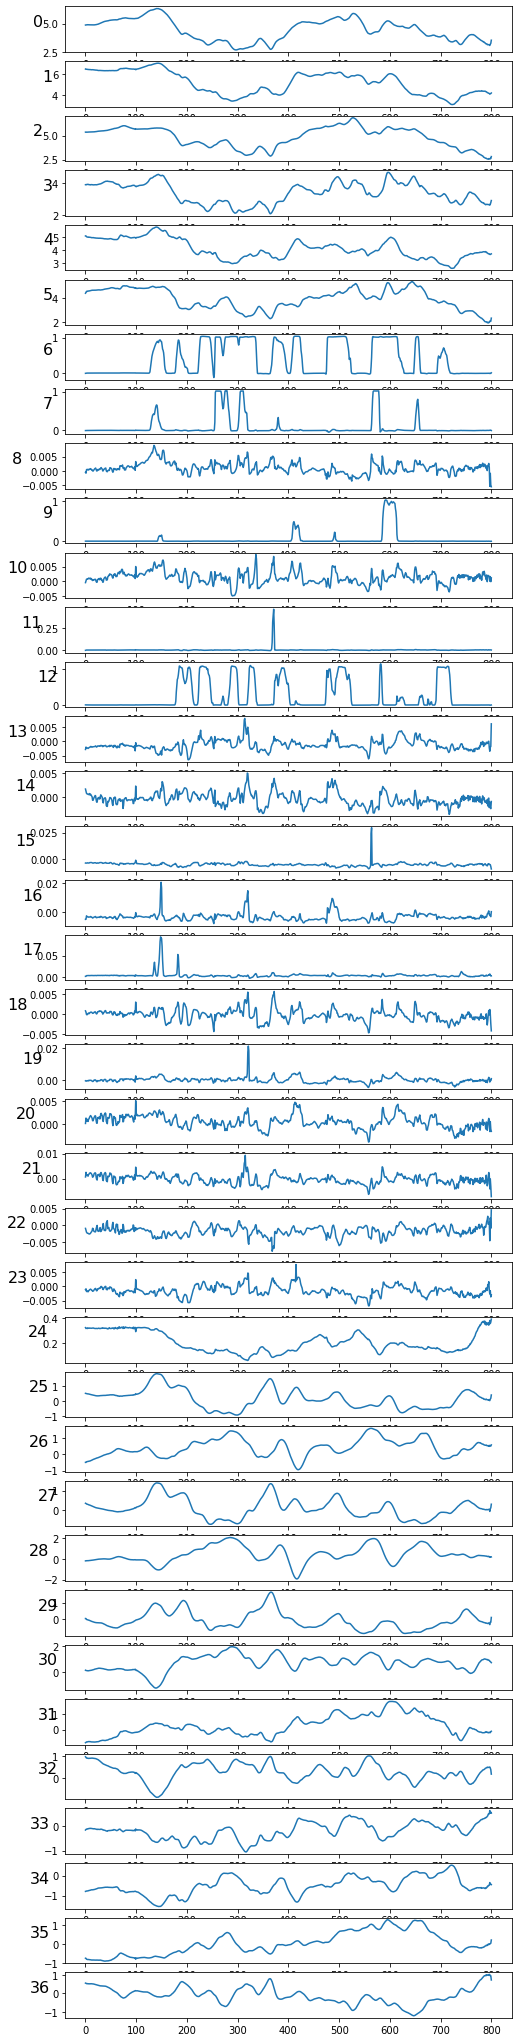

In [45]:
# plot estimated EMA sequence
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=pred.shape[1], ncols=1, figsize=(8,pred.shape[1]))
for art_i in range(pred.shape[1]):
      axes[art_i].plot(pred.cpu().numpy()[:, art_i])
      axes[art_i].set_ylabel('%d' % art_i, fontsize=16, rotation=0)

# EMA-to-Speech

In [40]:
# Load EMA-to-Speech model
synthesis_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_mocha2w_hifi_rd3pm/checkpoint-105000steps.pkl"
synthesis_config_path = "../exp/mocha_train_rd3pmf8nema_mocha2w_hifi_rd3pm/config.yml"

# load config
with open(synthesis_config_path) as f:
    synthesis_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    synthesis_device = torch.device("cuda")
else:
    synthesis_device = torch.device("cpu")
synthesis_model = load_model(synthesis_checkpoint_path, synthesis_config)
synthesis_model.remove_weight_norm()
synthesis_model = synthesis_model.eval().to(synthesis_device)

In [46]:
# Predict waveform for given EMA sequence
output_wav_path = "temp5.wav"

with torch.no_grad():
    c = pred.clone().detach()
    y = ar_loop(synthesis_model, c, synthesis_config)
    sf.write(
        output_wav_path,
        y.cpu().numpy(),
        synthesis_config["sampling_rate"],
        "PCM_16",
    )


# EMA-to-Mel-to-Speech

In [36]:
# Load EMA-to-Speech model
synthesis_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_mocha2m_tr_rd3pm/checkpoint-130000steps.pkl"
synthesis_config_path = "../exp/mocha_train_rd3pmf8nema_mocha2m_tr_rd3pm/config.yml"

# load config
with open(synthesis_config_path) as f:
    synthesis_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    synthesis_device = torch.device("cuda")
else:
    synthesis_device = torch.device("cpu")
synthesis_model = load_model(synthesis_checkpoint_path, synthesis_config)
synthesis_model.remove_weight_norm()
synthesis_model = synthesis_model.eval().to(synthesis_device)

In [37]:
with torch.no_grad():
    c = pred.clone().detach()
    c = c.transpose(0, 1)
    c = c.unsqueeze(0)
    mel_p = synthesis_model(c)
    print(mel_p.shape)

torch.Size([1, 80, 694])


/tmp/ipykernel_16322/1891931632.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(pred, dtype=torch.float).to(synthesis_device)


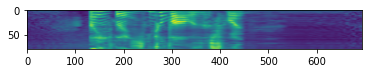

In [38]:
plt.imshow(mel_p[0].cpu().numpy())

In [21]:
# Load EMA-to-Speech model
vocoder_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_m2s_mocha/checkpoint-830000steps.pkl"
vocoder_config_path = "../exp/mocha_train_rd3pmf8nema_m2s_mocha/config.yml"

# load config
with open(vocoder_config_path) as f:
    vocoder_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    vocoder_device = torch.device("cuda")
else:
    vocoder_device = torch.device("cpu")
vocoder_model = load_model(vocoder_checkpoint_path, vocoder_config)
vocoder_model.remove_weight_norm()
vocoder_model = vocoder_model.eval().to(vocoder_device)

In [39]:
# Predict waveform for given EMA sequence
output_wav_path = "temp5.wav"

with torch.no_grad():
    print(mel_p[0].shape)
    y = ar_loop(vocoder_model, mel_p[0].transpose(0, 1), vocoder_config)
    sf.write(
        output_wav_path,
        y.cpu().numpy(),
        vocoder_config["sampling_rate"],
        "PCM_16",
    )


torch.Size([80, 694])


In [20]:
IPython.display.Audio(output_wav_path)
